# Forecasting HDB Resale Sale Prices in Singapore using Facebook Prophet
Book #2 - Refer to previous books for more information on compiled sales csv

### Aim : Identify sale price trends and forecast sales in the next year

### Strategy:

- Identify sale price trends using exploratory data analysis
- Observe price elasticity of supply & Demand
- Compare home price inflation versus true growth
- Use Prophet for price forecasting


In [1]:
# Import packages needed for the analysis

import pandas as pd
pd.set_option('display.max_columns', None)

import numpy as np
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# The compiled sales csv was created in book 1
sales = pd.read_csv('./compiled_sales.csv')

# Change the datetime by 
sales['month'] = pd.to_datetime(sales['month'], format ='%Y%m%')
print('after datetime change', sales.dtypes)

after datetime change Unnamed: 0                      int64
month                  datetime64[ns]
town                           object
flat_type                      object
block                          object
street_name                    object
storey_range                   object
floor_area_sqm                float64
flat_model                     object
lease_commence_date             int64
resale_price                  float64
resale_price_psf              float64
year                            int64
Month                           int64
remaining_lease                 int64
full_address                   object
dtype: object


In [3]:
# Divide data into geographical locations in Singapore

print(sales['town'].value_counts())
sales_north = sales[sales['town'].isin(['SEMBAWANG', 'PUNGGOL', 'YISHUN', 'WOODLANDS', 'ANG MO KIO', 'HOUGANG',  'SENGKANG', 'SERANGOON', 'LIM CHU KANG'])]
sales_east = sales[sales['town'].isin(['BEDOK', 'TAMPINES', 'PASIR RIS', ])]
sales_west = sales[sales['town'].isin(['JURONG WEST', 'BUKIT BATOK','CHOA CHU KANG', 'CLEMENTI', 'BUKIT PANJANG','JURONG EAST'])]
sales_central = sales[sales['town'].isin(['BUKIT MERAH', 'CENTRAL AREA', 'TOA PAYOH', 'QUEENSTOWN', 'KALLANG/WHAMPOA', 'GEYLANG','MARINE PARADE', 'BUKIT TIMAH'])]

TAMPINES           70778
YISHUN             60558
BEDOK              59656
JURONG WEST        58326
WOODLANDS          56315
ANG MO KIO         46907
HOUGANG            43836
BUKIT BATOK        39283
CHOA CHU KANG      32005
BUKIT MERAH        29397
PASIR RIS          29221
TOA PAYOH          27553
QUEENSTOWN         25201
CLEMENTI           25100
GEYLANG            24924
KALLANG/WHAMPOA    23276
BUKIT PANJANG      22654
JURONG EAST        22147
SENGKANG           20958
SERANGOON          20516
BISHAN             18940
PUNGGOL            10299
SEMBAWANG          10143
MARINE PARADE       7227
CENTRAL AREA        6114
BUKIT TIMAH         2198
LIM CHU KANG          64
Name: town, dtype: int64


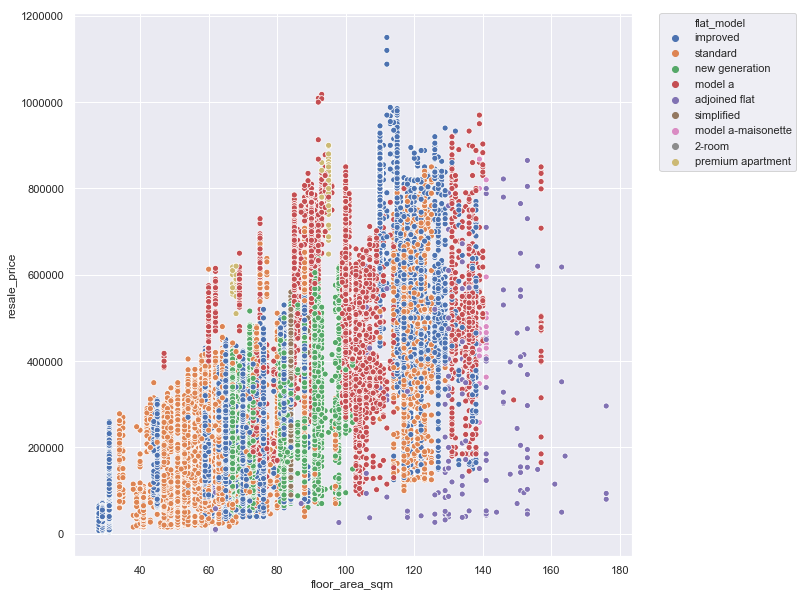

In [4]:
# How the Home prices differ per flat model

example_data = sales[sales['town'] == 'BUKIT MERAH']

sns.set(rc={'figure.figsize':(10,10)})
sns.scatterplot(x = 'floor_area_sqm', y = 'resale_price', data = example_data, hue = 'flat_model')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

### Visualization of data
- View the changes in price per sqft per region in Singapore
- In general prices increase by sqft of the flat. Therefore, we normalize the flat price per sqft. 

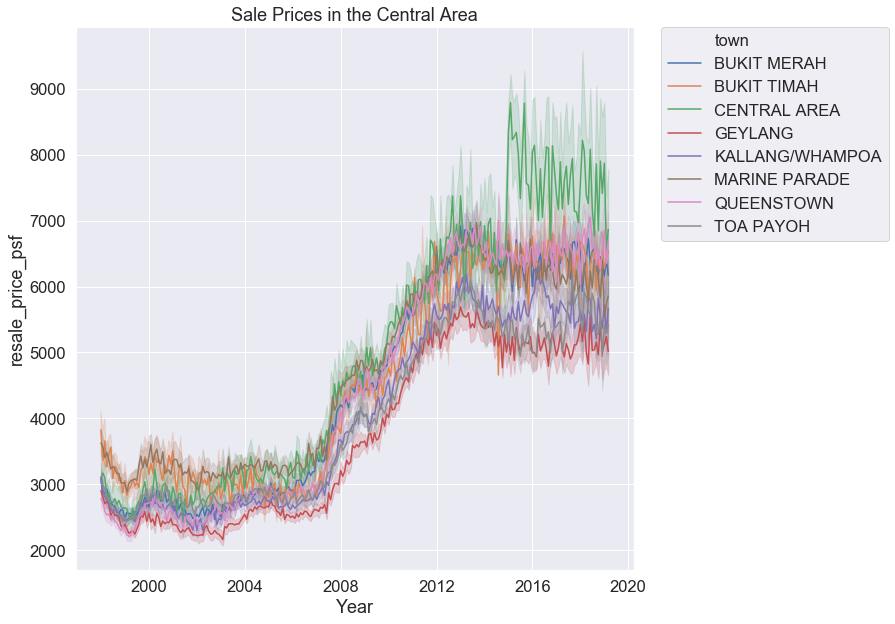

In [437]:
sns.set(rc={'figure.figsize':(10,10)}, font_scale = 1.5)
sns.lineplot(x = 'month', y = 'resale_price_psf', data = sales_central, hue = 'town')
plt.title('Sale Prices in the Central Area')
plt.xlabel('Year')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

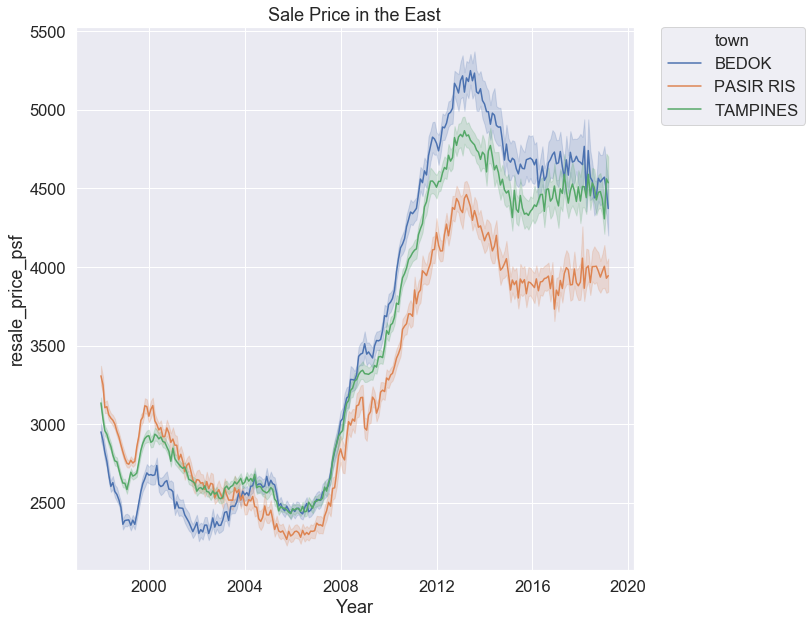

In [438]:
sns.lineplot(x = 'month', y = 'resale_price_psf', data = sales_east, hue = 'town')
plt.title('Sale Price in the East')
plt.xlabel('Year')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

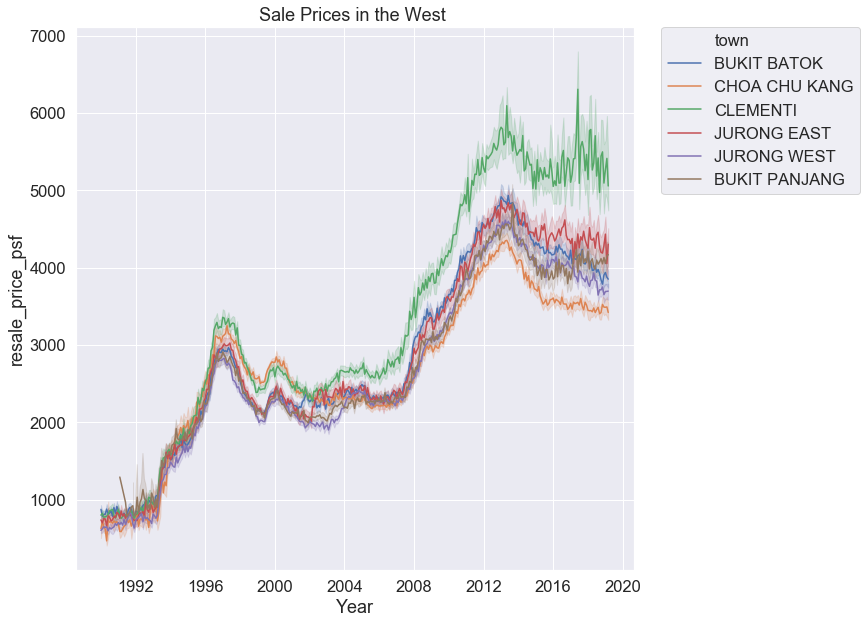

In [439]:

sns.lineplot(x = 'month', y = 'resale_price_psf', data = sales_west, hue = 'town')
plt.title('Sale Prices in the West ')
plt.xlabel('Year')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


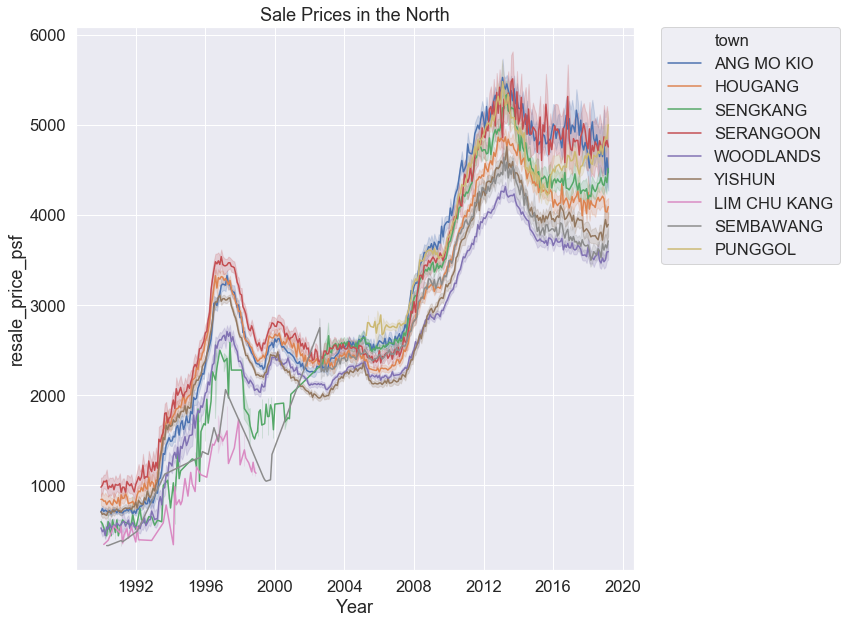

In [440]:
sns.lineplot(x = 'month', y = 'resale_price_psf', data = sales_north, hue = 'town')
plt.title('Sale Prices in the North')
plt.xlabel('Year')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

## Understanding the Financial Drivers of Resale Market

**Family Income**

In [206]:
# Monthly Family income 
earnings = pd.read_csv('./average-mean-monthly.csv')

In [207]:
new = earnings['quarter'].str.split('-', n = 2, expand = True) 

In [208]:
earnings['quarter'] = new[0]

In [209]:
earnings = earnings[earnings['sex'] == 'total']

In [246]:
year = earnings.groupby('quarter').mean()['average_monthly_earnings'].index
salaries_1 = list(earnings.groupby('quarter').mean()['average_monthly_earnings'])

salaries = pd.DataFrame(year)
salaries['quarter'] = salaries['quarter'].apply(lambda x : int(x))
salaries['salaries'] = salaries_1

In [389]:
salaries.index = salaries['quarter']
salaries.drop(columns = ['quarter'], inplace = True)

In [392]:
# Average Growth Salaries per year:

earnings_change = []

for i in list(salaries.index):
    if i < 2018:
        p2_p1 = (salaries.loc[i+1,'salaries'] - salaries.loc[i,'salaries']) # Change
        p1 = salaries.loc[i,'salaries'] # Initial Price
        change = (p2_p1 / p1) * 100
        
        earnings_change.append(change)


In [395]:
print('Average Salary Change Per Year', round(np.mean(earnings_change),2), '%')

Average Salary Change Per Year 3.49 %


In [413]:
# Average Growth Salaries per year:

sales_east = sales_east[sales_east['year'] >1997]
east_price = sales_east.groupby('year').mean()[['resale_price_psf']]

salePrice_changes = []
year = []
for i in east_price.index:
    if i < 2018:
        p2_p1 = (east_price.loc[i+1,'resale_price_psf'] - east_price.loc[i,'resale_price_psf']) # Change
        p1 = east_price.loc[i,'resale_price_psf'] # Initial Price
        change = (p2_p1 / p1) * 100
        
        salePrice_changes.append(change)
        year.append(i+1)

In [428]:
# Average Growth Salaries per year:

sales_central = sales_central[sales_central['year'] >1997]
central_price = sales_central.groupby('year').mean()[['resale_price_psf']]

salePrice_changes_central = []
year = []
for i in central_price .index:
    if i < 2018:
        p2_p1 = (central_price .loc[i+1,'resale_price_psf'] - central_price .loc[i,'resale_price_psf']) # Change
        p1 = central_price .loc[i,'resale_price_psf'] # Initial Price
        change = (p2_p1 / p1) * 100
        
        salePrice_changes_central.append(change)
        year.append(i+1)

In [429]:
print('Average Home Change Per Year', round(np.mean(salePrice_changes),2), '%')

Average Home Change Per Year 2.54 %


In [430]:
print('Average Home Change Per Year Central', round(np.mean(salePrice_changes_central),2), '%')

Average Home Change Per Year Central 4.37 %


In [431]:
from scipy import stats
print(stats.ttest_ind(salePrice_changes,earnings_change))
print(stats.ttest_ind(salePrice_changes_central,earnings_change))
print('They are not significantly different')

Ttest_indResult(statistic=-0.544323226382636, pvalue=0.5893991107040262)
Ttest_indResult(statistic=0.5054065267823984, pvalue=0.6161924199016893)
They are not significantly different


In [433]:
growth = pd.DataFrame(year, columns = ['year'])
growth['sale_price'] = salePrice_changes
growth['salaries'] = earnings_change
growth['sale_price_central'] = salePrice_changes_central
growth['zero'] = 0

Text(0.5, 1.0, 'Growth of Salaries & Home Prices in Singapore')

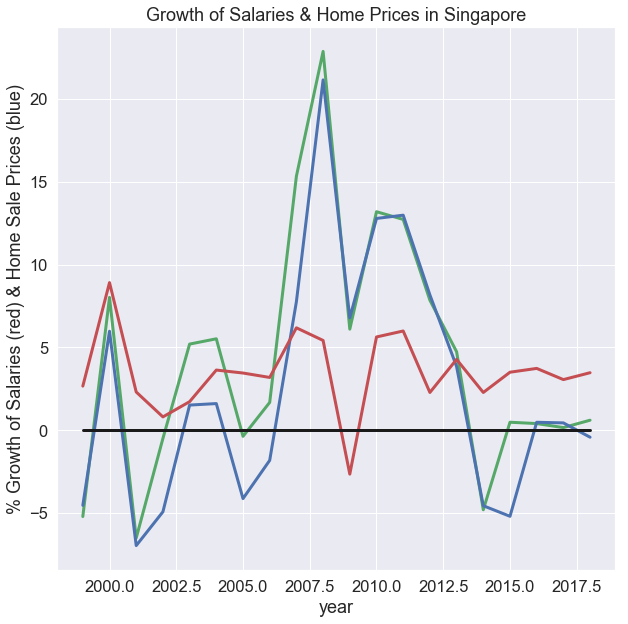

In [434]:
sns.set(rc={'figure.figsize':(10,10), "lines.linewidth": 3}, font_scale = 1.5)

sns.lineplot(x = 'year', y = 'sale_price_central', data = growth, color = 'g')
sns.lineplot(x = 'year', y = 'sale_price', data = growth, color = 'b')
sns.lineplot(x = 'year', y = 'salaries', data = growth, color = 'r')

sns.lineplot(x = 'year', y = 'zero', data = growth, color = 'k')
plt.ylabel('% Growth of Salaries (red) & Home Sale Prices (blue)')
plt.title('Growth of Salaries & Home Prices in Singapore')

**Supply - Number of Flats Built**

In [452]:
flats = pd.read_csv('./flats-constructed.csv')

# add 5 years to the year since they only become available for sale only 5 years after purchase
flats['year'] = flats['year'].apply(lambda x : x+5)

# flats only after 1990
flats = flats[flats['year']>= 1990]


In [455]:
flats = flats[flats['year']>= 1990]
flats = flats[flats['year'] < 2019]

**Demand - Number of Applications to HDB for resale flat ownership**

In [193]:
# represents the demand over 5 years
demand = pd.read_csv('./demand.csv')

# Earliest date = 1990
demand = demand[demand['end_year']>= 1990]

#average demand per year 
demand['demand_for_flats'] = demand['demand_for_flats'].apply(lambda x : x/5)

# Home ownership only
demand = demand[demand['flat_type']== 'home_ownership_flats']

In [197]:
demand = demand[['end_year', 'flat_type', 'demand_for_flats']]
demand.columns = ['year', 'flat_type', 'demand_for_flats']

In [476]:
sales['month'] = pd.to_datetime(sales['month'], format ='%Y%m%')
print('after datetime change', sales.dtypes)

Index(['Unnamed: 0', 'month', 'town', 'flat_type', 'block', 'street_name',
       'storey_range', 'floor_area_sqm', 'flat_model', 'lease_commence_date',
       'resale_price'],
      dtype='object')

In [479]:


sales = pd.read_csv('./compiled_sales.csv')

sale_price = sales.groupby('year').mean()[['resale_price_psf']]
sale_price_2 = sale_price.reset_index()

Text(0.5, 0, 'Year')

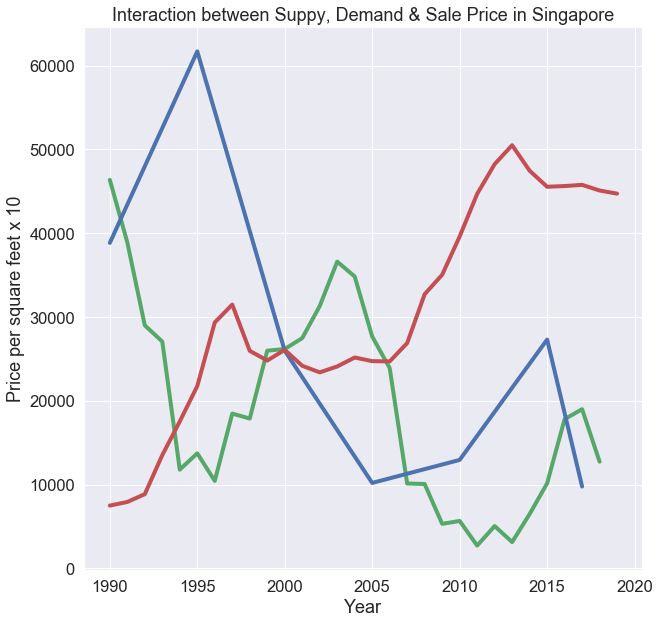

In [483]:
plt.plot(flats['year'], flats['flats_constructed'], linewidth = 4, color = 'g')
plt.plot(demand['year'], demand['demand_for_flats'], linewidth = 4, color = 'b')
plt.plot(sale_price_2['year'],sale_price_2['resale_price_psf']*10, linewidth = 4, color = 'r')
plt.title('Interaction between Suppy, Demand & Sale Price in Singapore')
plt.ylabel('Price per square feet x 10')
plt.xlabel('Year')

In [363]:
# Price Elasticity of Supply


east_price = sales_east.groupby('year').mean()[['resale_price_psf']]
east_price_2 = east_price.reset_index()

price_changes = []
year_change = []
for i in list(east_price_2['year']):
    if i < 2018:
        p2_p1 = (east_price.loc[i+1,'resale_price_psf'] - east_price.loc[i,'resale_price_psf']) # Change
        p2_p1_add = (east_price.loc[i+1,'resale_price_psf'] + east_price.loc[i,'resale_price_psf']) # Sum of Prices
        den = p2_p1_add / 2 # Find Mid Point
    
        change = p2_p1 / den
        year = i+1
    
        price_changes.append(change)
        year_change.append(year)


In [364]:
supply_change = []

for i in list(flats.index):
    if i < 2018:
        p2_p1 = (flats.loc[i+1,'flats_constructed'] - flats.loc[i,'flats_constructed']) # Change
        p2_p1_add = (flats.loc[i+1,'flats_constructed'] + flats.loc[i,'flats_constructed']) # Sum of Prices
        den = p2_p1_add / 2 # Find Mid Point
    
        change = p2_p1 / den
        year = i+1
    
        supply_change.append(change)


In [365]:
elasticity = pd.DataFrame(supply_change, columns =['supply_change'])
elasticity['price_changes'] = price_changes
elasticity['year'] = year_change

elasticity['supply_elasticity'] = elasticity['supply_change'] / elasticity['price_changes']
elasticity['zero_line'] = 0

Text(0.5, 1.0, 'Elasticity of HDB Supply in Singapore')

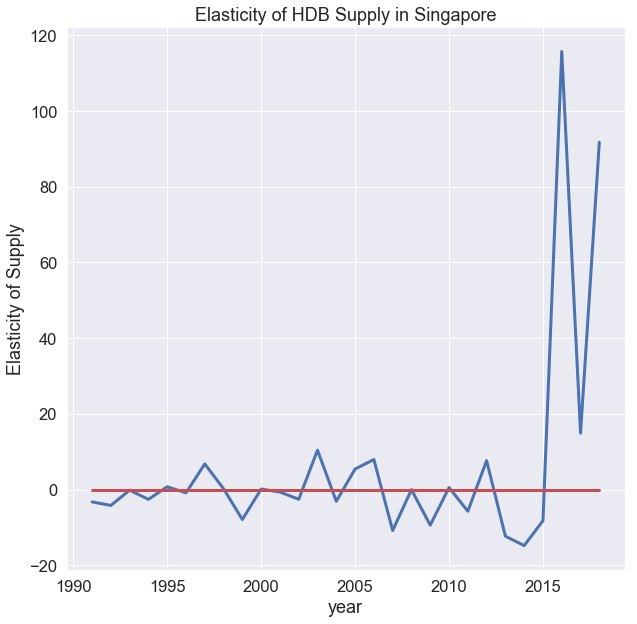

In [366]:
sns.set(rc={'figure.figsize':(10,10), "lines.linewidth": 3}, font_scale = 1.5)

sns.lineplot(x = 'year', y = 'supply_elasticity', data = elasticity, color = 'b')
sns.lineplot(x = 'year', y = 'zero_line', data = elasticity, color = 'r')
plt.ylabel('Elasticity of Supply')
plt.title('Elasticity of HDB Supply in Singapore')

In [367]:
units_soldperyear = sales_east.groupby('year').count()[['month']]
units_soldperyear.head()

,month
year,
1990,2093
1991,2010
1992,3363
1993,4334
1994,6429


In [368]:
demand_change = []

for i in list(units_soldperyear.index):
    if i < 2018:
        p2_p1 = (units_soldperyear.loc[i+1,'month'] - units_soldperyear.loc[i,'month']) # Change
        p2_p1_add = (units_soldperyear.loc[i+1,'month'] + units_soldperyear.loc[i,'month']) # Sum of Prices
        den = p2_p1_add / 2 # Find Mid Point
    
        change = p2_p1 / den
        year = i+1
    
        demand_change.append(change)


In [369]:
elasticity_d = pd.DataFrame(demand_change, columns =['demand_change'])
elasticity_d['price_changes'] = price_changes
elasticity_d['year'] = year_change

elasticity_d['demand_elasticity'] = elasticity_d['demand_change'] / elasticity_d['price_changes']
elasticity_d['zero_line'] = 0

Text(0.5, 1.0, 'Elasticity of HDB Demand in Singapore')

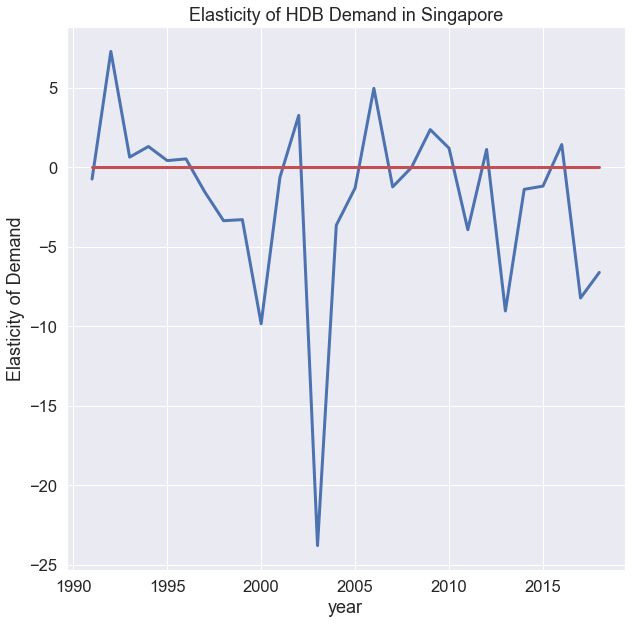

In [370]:
sns.set(rc={'figure.figsize':(10,10), "lines.linewidth": 3}, font_scale = 1.5)

sns.lineplot(x = 'year', y = 'demand_elasticity', data = elasticity_d, color = 'b')
sns.lineplot(x = 'year', y = 'zero_line', data = elasticity_d, color = 'r')
plt.ylabel('Elasticity of Demand')
plt.title('Elasticity of HDB Demand in Singapore')

In [371]:
def supply_and_demand(df, region):
    # Unique years of data
    year = df['year'].unique()

    # Number of units sold per year
    units_soldperyear = list(df.groupby(['year'])['town'].count())
    
    # Units sold per year 
    
    
    # get the average price per sqft 
    price_per_sqft = list(df.groupby(['year'])['resale_price_psf'].mean())
    # plot graph
    plt.bar(year, units_soldperyear)
    plt.plot(year, price_per_sqft, 'r', linewidth=5.0)
    plt.title('Units Sold and Mean Sale Prices for {}'.format(region))
    plt.ylabel('Units sold (blue) & Average price (red)')
    plt.xlabel('Year of Sale')
    plt.show()

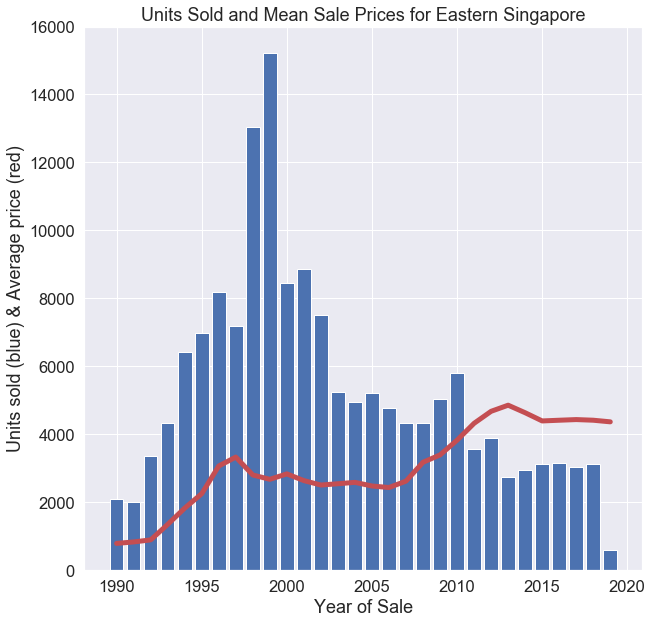

In [335]:
sns.set(rc={'figure.figsize':(10,10), "lines.linewidth": 3}, font_scale = 1.5)
supply_and_demand(sales_east, 'Eastern Singapore')

**The number of sales in the east has greatly diminished, but the prices have risen substantially.**
- Rationale: The decrease in supplies, but the great proximity to train stations and malls makes this region very attractive to locals. The prices may be driven by the availability of units. 

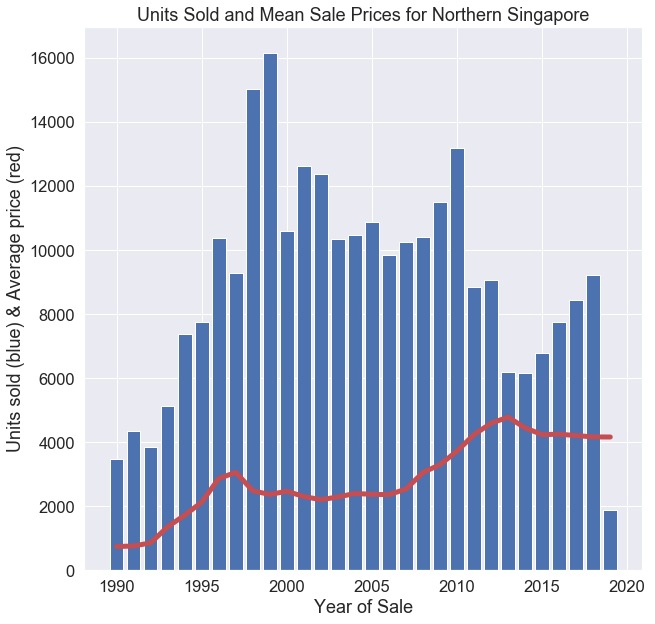

In [373]:
supply_and_demand(sales_north, 'Northern Singapore')

**In Northern Singapore, the number of units sold post-2010 are nearly 2x the sales of east and west** 
- Rationale: The north may be expanding at a higher rate than the east and west, and therefore the number of units sold does not affect the price as much. 
- Alternatively, the east and west may dictate the prices via supply and demand and the north follows the trends. 

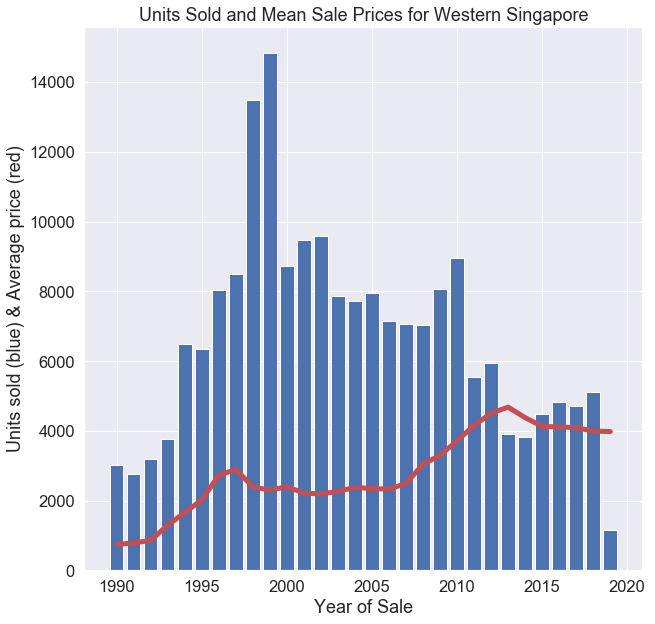

In [374]:
supply_and_demand(sales_west, 'Western Singapore')

**In Western Singapore, similar to eastern Singapore, the prices are invertely correlated with the number of units sold** 
- Rationale: This region is mostly populated by Singaporeans. The market is more dynamic and dictated by supply and demand rather than 'hot spot'.  


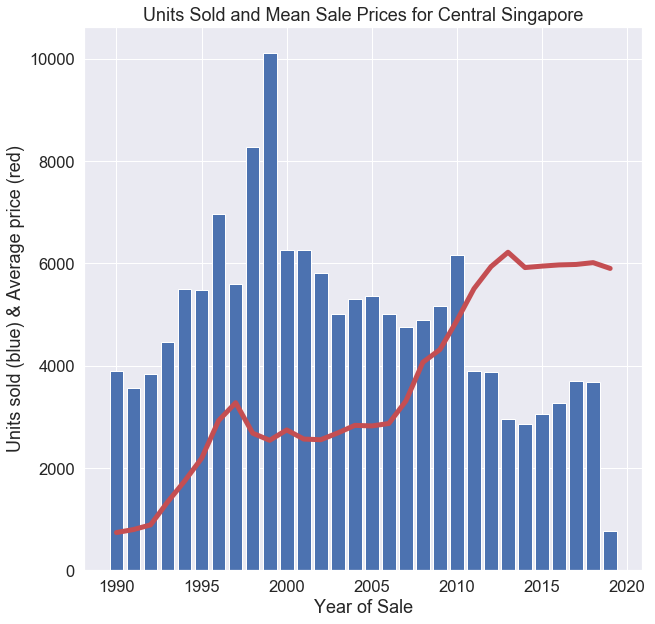

In [375]:
supply_and_demand(sales_central, 'Central Singapore')

In [ ]:
# Simulating inflation



**In Central Singapore, the price has always been much higher than the supply** 
- Rationale: This region has always been in high demand, but there is little space, thus the prices are always inflated. 


## Forecasting Sale Prices using Prophet
- This tool allows to forecast sales in the next 2 years
- It also allows to view yearly changes in sale prices

Here once more, we use the resale price per square foot for the analysis

In [112]:
# reformat into a time-series dataset for each location
prophet_central = sales_central[['month', 'resale_price_psf']]
prophet_east = sales_east[['month', 'resale_price_psf']]
prophet_west = sales_west[['month', 'resale_price_psf']]
prophet_north = sales_north[['month', 'resale_price_psf']]

In [113]:
prophet_central.head(5)

,month,resale_price_psf
410,1990-01-01,251.724138
411,1990-01-01,251.724138
412,1990-01-01,310.344828
413,1990-01-01,306.451613
414,1990-01-01,235.483871


In [16]:
# change the column names to a format recognized by prophet

prophet_central.columns = ['ds', 'y']
prophet_east.columns = ['ds', 'y']
prophet_west.columns = ['ds', 'y']
prophet_north.columns = ['ds', 'y']

## Forecasting For Central Resale Flats

In [17]:
m = Prophet()
m.fit(prophet_central)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [18]:
future = m.make_future_dataframe(periods=90)
future.tail()

,ds
145975,2019-05-26
145976,2019-05-27
145977,2019-05-28
145978,2019-05-29
145979,2019-05-30


In [19]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
145975,2019-05-26,6232.263721,5200.857297,7283.716287
145976,2019-05-27,6229.315758,5199.535387,7233.685306
145977,2019-05-28,6223.455200,5207.314049,7265.206653
145978,2019-05-29,6214.765057,5221.888106,7234.737442
145979,2019-05-30,6203.398879,5253.489715,7199.968462


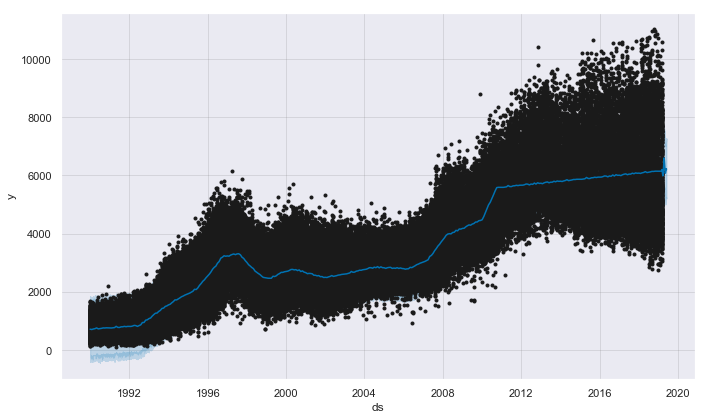

In [20]:
fig1 = m.plot(forecast)

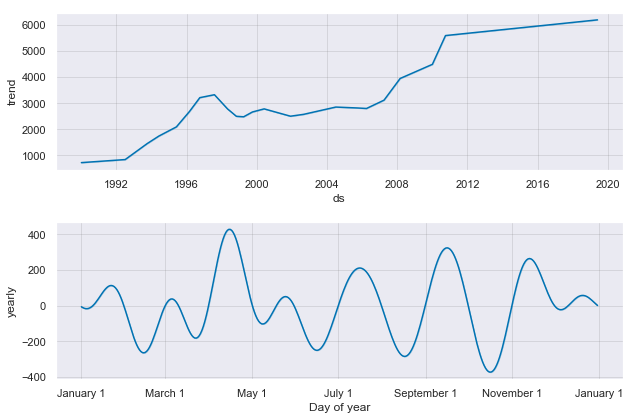

In [21]:
fig2 = m.plot_components(forecast)

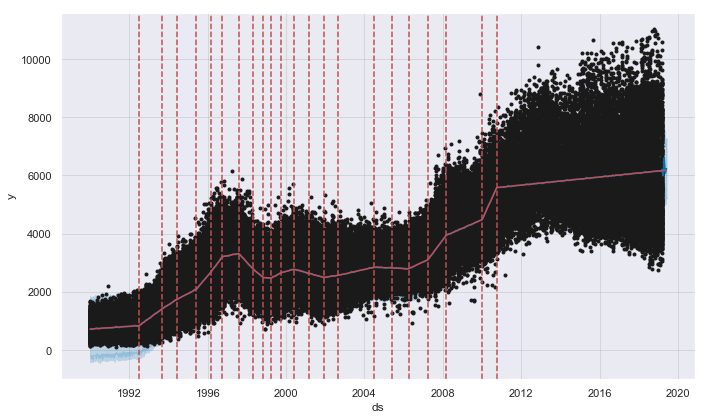

In [22]:
#change points


fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)


## Forecasting For Eastern Resale Flats

In [23]:
me = Prophet()
me.fit(prophet_east)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [24]:
future_e = me.make_future_dataframe(periods=90)
future_e.tail()

,ds
159740,2019-05-26
159741,2019-05-27
159742,2019-05-28
159743,2019-05-29
159744,2019-05-30


In [25]:
forecast_e = me.predict(future_e)
forecast_e[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
159740,2019-05-26,4631.279587,4068.235058,5156.331116
159741,2019-05-27,4634.112753,4090.766893,5181.752291
159742,2019-05-28,4638.165844,4077.151302,5239.115030
159743,2019-05-29,4643.510664,4107.787784,5220.564034
159744,2019-05-30,4650.186591,4088.442626,5240.830641


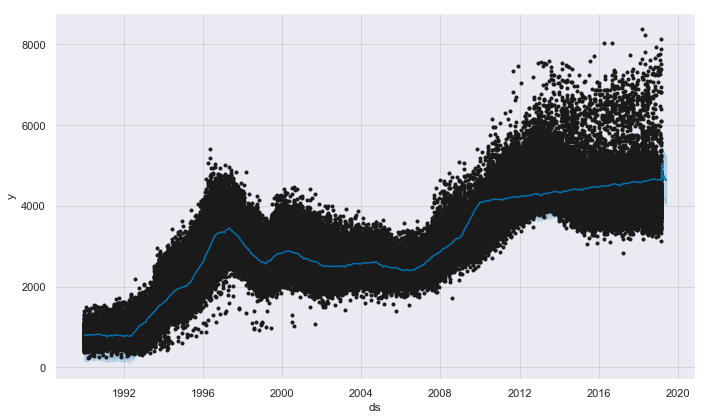

In [26]:
fig1 = me.plot(forecast_e)

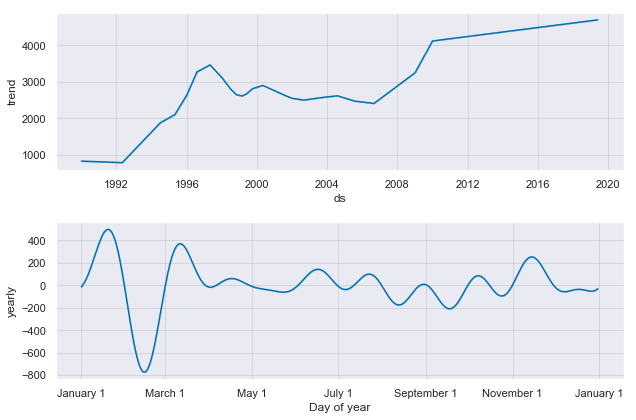

In [27]:
fig2 = me.plot_components(forecast_e)

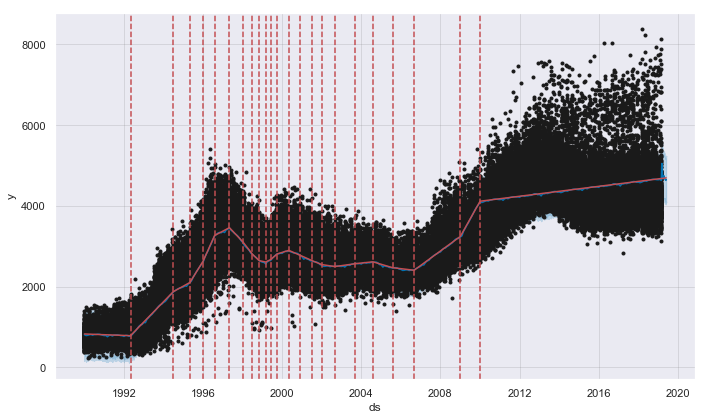

In [28]:
#change points

fig = me.plot(forecast_e)
a = add_changepoints_to_plot(fig.gca(), me, forecast_e)


## Forecasting For Western Resale Flats

In [29]:
mw = Prophet()
mw.fit(prophet_west)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [30]:
future_w = mw.make_future_dataframe(periods=90)
future_w.tail()

,ds
199600,2019-05-26
199601,2019-05-27
199602,2019-05-28
199603,2019-05-29
199604,2019-05-30


In [31]:
forecast_w = mw.predict(future_w)
forecast_w[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
199600,2019-05-26,4077.421218,3426.563782,4663.402640
199601,2019-05-27,4066.109196,3453.481899,4708.265439
199602,2019-05-28,4055.514637,3445.951821,4736.098577
199603,2019-05-29,4045.890417,3401.748861,4631.966545
199604,2019-05-30,4037.456922,3430.282164,4639.896382


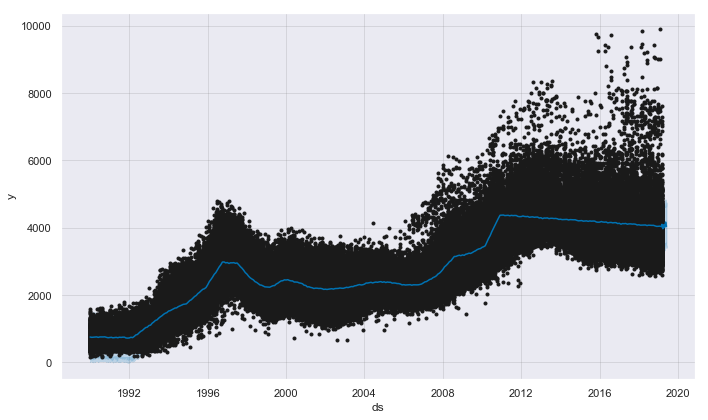

In [32]:
fig1 = mw.plot(forecast_w)

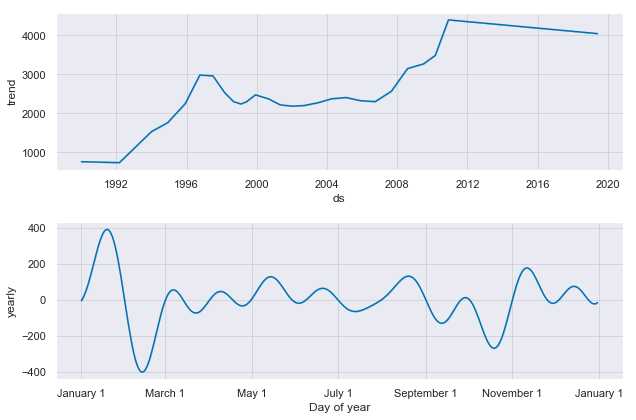

In [33]:
fig2 = mw.plot_components(forecast_w)

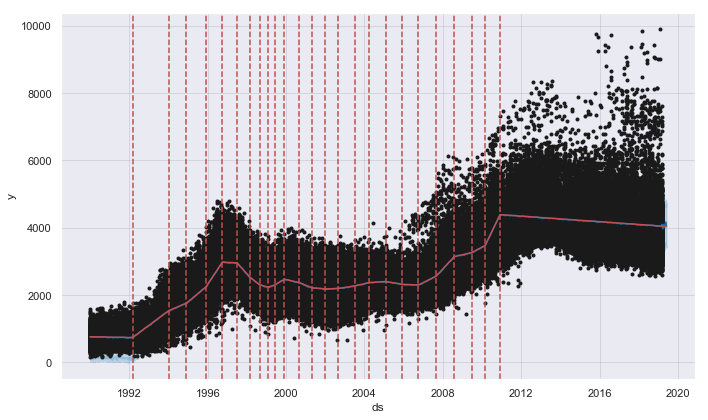

In [34]:
#change points

fig = mw.plot(forecast_w)
a = add_changepoints_to_plot(fig.gca(), mw, forecast_w)


## Forecasting For Northern Resale Flats

In [35]:
mn = Prophet()
mn.fit(prophet_north)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [36]:
future_n = mn.make_future_dataframe(periods=90)
future_n.tail()

,ds
269681,2019-05-26
269682,2019-05-27
269683,2019-05-28
269684,2019-05-29
269685,2019-05-30


In [37]:
forecast_n = mn.predict(future_n)
forecast_n[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
269681,2019-05-26,4010.100731,3376.148463,4618.027425
269682,2019-05-27,4014.552126,3440.498897,4616.712648
269683,2019-05-28,4019.617436,3396.901690,4657.729585
269684,2019-05-29,4025.087058,3412.301632,4655.564697
269685,2019-05-30,4030.735655,3442.876435,4657.977633


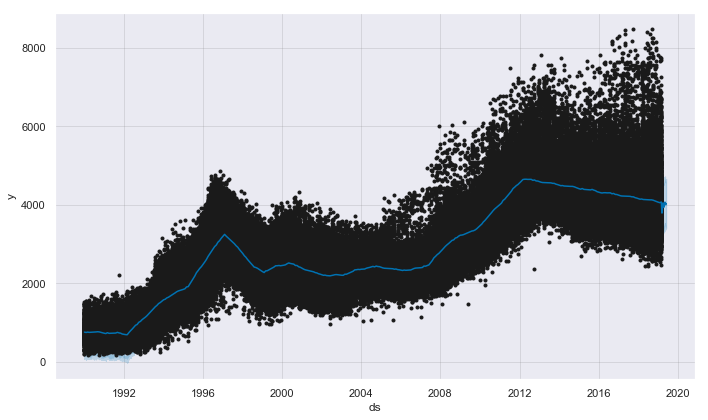

In [38]:
fig1 = mn.plot(forecast_n)

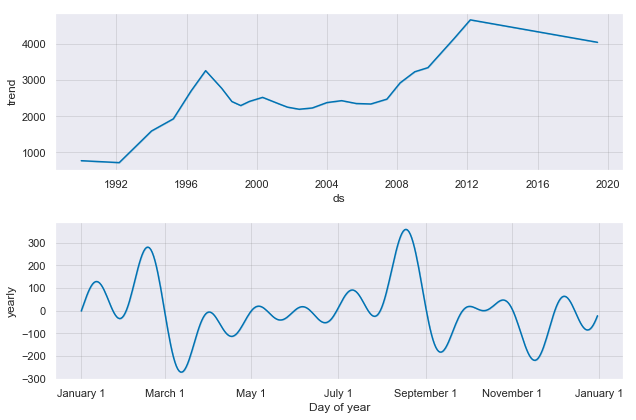

In [39]:
fig2 = mn.plot_components(forecast_n)

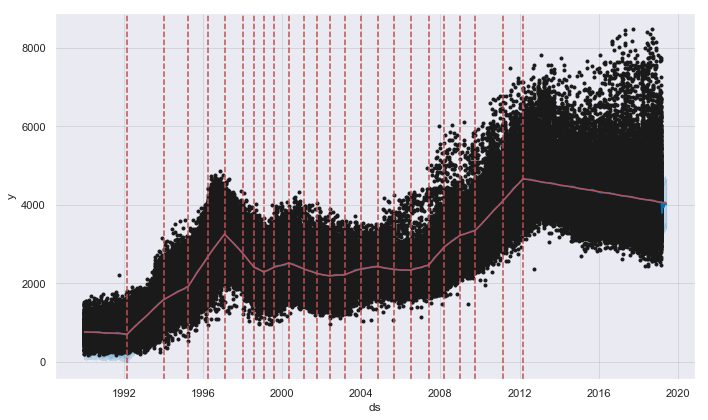

In [40]:
#change points

fig = mn.plot(forecast_n)
a = add_changepoints_to_plot(fig.gca(), mn, forecast_n)


## Visualizing all the Forecasts into one graph for the last 5 years 
2015 to forecast

Text(0.5, 0, 'Date')

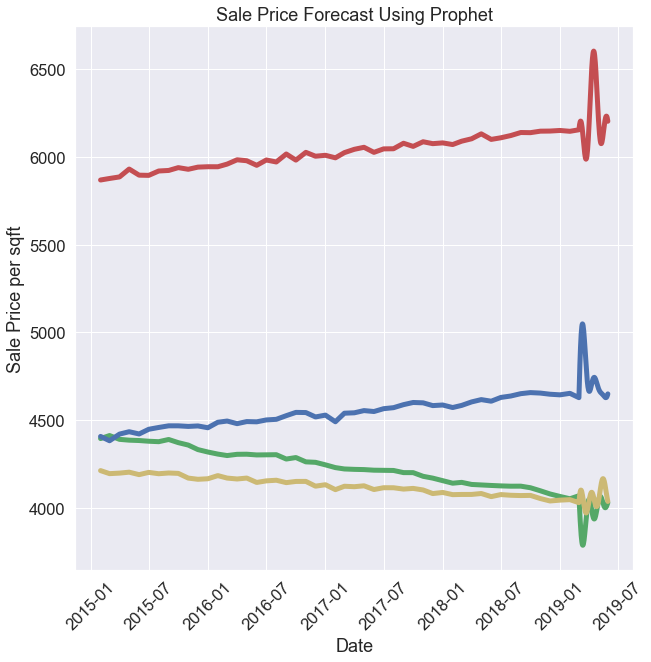

In [380]:
forecast_n = forecast_n[forecast_n['ds'] > '2015-01-01'][['ds', 'yhat']]
forecast = forecast[forecast['ds'] > '2015-01-01'][['ds', 'yhat']]
forecast_e = forecast_e[forecast_e['ds'] > '2015-01-01'][['ds', 'yhat']]
forecast_w = forecast_w[forecast_w['ds'] > '2015-01-01'][['ds', 'yhat']]

plt.plot(forecast_n['ds'], forecast_n['yhat'],'g', label = 'East', linewidth=5)
plt.plot(forecast['ds'], forecast['yhat'],'r', label = 'North', linewidth=5)
plt.plot(forecast_e['ds'], forecast_e['yhat'],'b', label = 'East', linewidth=5)
plt.plot(forecast_w['ds'], forecast_w['yhat'],'y', label = 'West', linewidth=5)
plt.xticks(rotation = 45)
plt.title('Sale Price Forecast Using Prophet')
plt.ylabel('Sale Price per sqft')
plt.xlabel('Date')

**It is very hard to forecast the housing market for an entire region, although most of the towns show stable sale prices in the last 5 years.** 

**From our above analysis, one town had low variability & a decline in sale price:**
- Woodlands (North)

We will use these to predict future prices

In [42]:
# a dataframe for prophet for properties in woodlands only
prophet_woodlands = sales_north[sales_north['town'] == 'WOODLANDS'][['month', 'resale_price_psf']]
prophet_woodlands.columns = ['ds', 'y']

In [43]:
mwo = Prophet()
mwo.fit(prophet_woodlands)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [44]:
future_wo = mwo.make_future_dataframe(periods=90)
future_wo.tail()

,ds
56400,2019-05-26
56401,2019-05-27
56402,2019-05-28
56403,2019-05-29
56404,2019-05-30


In [45]:
forecast_wo = mwo.predict(future_wo)
forecast_wo[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
56400,2019-05-26,3233.638085,2833.213954,3638.323567
56401,2019-05-27,3259.080988,2852.312110,3664.676688
56402,2019-05-28,3288.070163,2880.381713,3698.809698
56403,2019-05-29,3320.168109,2899.753772,3701.201662
56404,2019-05-30,3354.865167,2950.798754,3802.045101


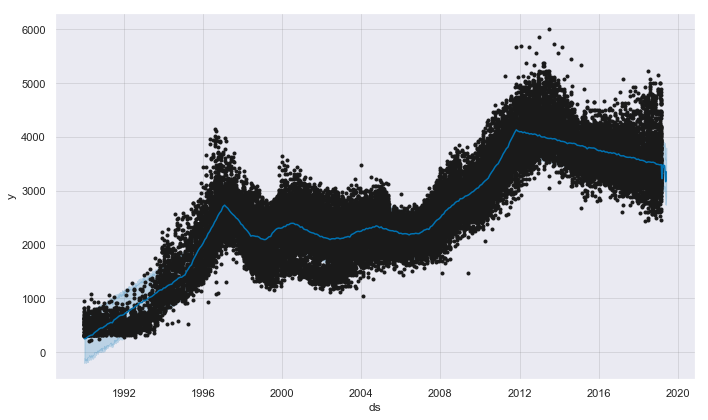

In [46]:
fig1 = mwo.plot(forecast_wo)

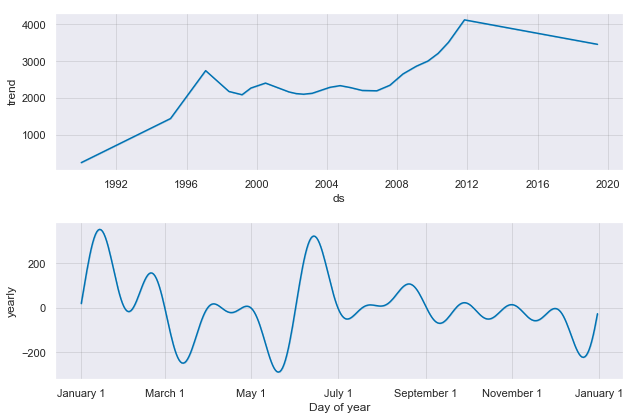

In [47]:
fig2 = mwo.plot_components(forecast_wo)

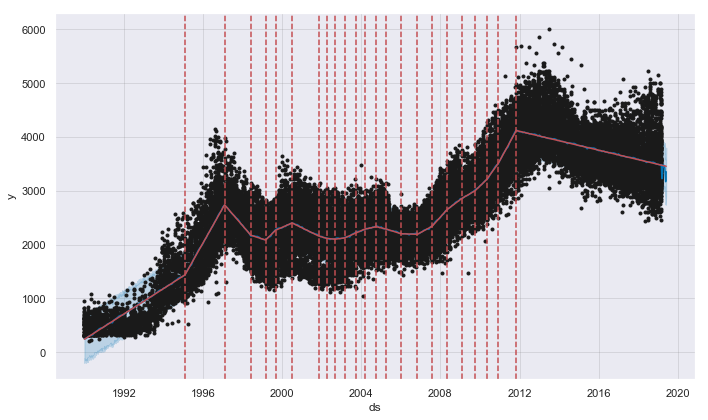

In [48]:
#change points

fig = mwo.plot(forecast_wo)
a = add_changepoints_to_plot(fig.gca(), mwo, forecast_wo)